In [1]:
#import 
import pyspark
from pyspark import SparkContext #for unabling to set up sc by yourself
from pyspark.sql import SparkSession, SQLContext #spark dataframe = spark sql
from pyspark.sql.functions import to_date, col, count,when,lit,rand,to_timestamp,udf
from pyspark.sql.functions import concat_ws, substring,isnan,regexp_replace,concat
from pyspark.sql.functions import udf,regexp_extract, monotonically_increasing_id
from pyspark.ml.feature import Imputer

#building spark session
appname = "homework4" #define app name
master = "local"

config = pyspark.SparkConf().setAppName(appname)\
.setMaster(master) #we do not have any workers.


#session
#with sql context, create session from it
sc  = SparkContext.getOrCreate(conf=config)
sqlContext = SQLContext(sc)
#don't create many sessions, take up too much room!
sp_session = sqlContext.sparkSession.builder.getOrCreate();
#export data into postgresql
from pyspark import SparkContext, SparkConf, SQLContext

#define a function to read data from previous homework
def read_data(tablename):
    play_df = sqlContext.read.format("jdbc")\
    .option("url", "jdbc:postgresql://localhost:5432/postgres")\
    .option("dbtable", tablename)\
    .option("user", "postgres")\
    .option("password", "postgres")\
    .option("Driver", "org.postgresql.Driver")\
    .load()
    play_df.printSchema()
    return play_df
    

/Library/Spark/spark-3.2.1-bin-hadoop3.2-scala2.13/python/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
#ingest data from previous play data in postgres

plays_df =read_data("NFL.PLAYS")
team_plays = read_data("NFL.SPECIAL_TM_PLAY")

root
 |-- gameid: string (nullable = true)
 |-- playid: string (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- gameclock: timestamp (nullable = true)
 |-- down: integer (nullable = true)
 |-- yardsToGo: integer (nullable = true)
 |-- possessionTeam: string (nullable = true)
 |-- yardlineSide: string (nullable = true)
 |-- yardlineNumber: string (nullable = true)
 |-- offenseFormation: string (nullable = true)
 |-- personnel_off: string (nullable = true)
 |-- personnel_def: string (nullable = true)
 |-- isPenalty: boolean (nullable = true)
 |-- isSTPlay: boolean (nullable = true)
 |-- PassResult: string (nullable = true)
 |-- PlayResult: integer (nullable = true)
 |-- Pass_Length: integer (nullable = true)
 |-- YardAfterCatch: integer (nullable = true)
 |-- defenders_InTheBox: integer (nullable = true)
 |-- number_PassRushers: integer (nullable = true)
 |-- Play_Description: string (nullable = true)
 |-- Player_1: string (nullable = true)
 |-- Player_2: string (nullable =

In [3]:
#create the target variable, and set it to string data type
#join teamplay data into plays data
plays_df.select("PassResult").distinct().show()
team_plays.show(10)
plays_with_teamplay = plays_df.join(team_plays,plays_df.SpTeamPlayId  == team_plays.SpTeamPlayId).drop("SpTeamPlayId")
#select columns that would be needed as features 
plays_with_caughtpass= plays_with_teamplay.withColumn("result", when(col("PassResult")=="C","1").otherwise("0"))\
.select("playid","result","SpecialTeamsPlayType","possessionTeam","isSTPlay","offenseFormation",
        "personnel_off","personnel_def","yardlineSide",
        "yardlineNumber","KickReturn","number_PassRushers","defenders_InTheBox","YardAfterCatch",
       "Pass_Length","yardsToGo").withColumn("yardline_number", col("yardLineNumber").cast("int")).drop("yardLineNumber")
plays_with_caughtpass.printSchema()
plays_with_caughtpass.groupBy("result").count().show()

+----------+
|PassResult|
+----------+
|        NA|
|         C|
|        IN|
|         S|
|         R|
|         I|
+----------+

+--------------------+----------+--------------+
|SpecialTeamsPlayType|KickReturn|  SpTeamPlayId|
+--------------------+----------+--------------+
|                Punt|         1|SpTmPlayID_286|
|                Punt|        49|SpTmPlayID_769|
|             Kickoff|        38|SpTmPlayID_464|
|             Kickoff|        26|SpTmPlayID_742|
|                Punt|        16| SpTmPlayID_78|
|             Kickoff|        50|SpTmPlayID_281|
|             Kickoff|        20|SpTmPlayID_120|
|             Kickoff|        29| SpTmPlayID_89|
|                  NA|        15|SpTmPlayID_826|
|                Punt|         3|SpTmPlayID_544|
+--------------------+----------+--------------+
only showing top 10 rows

root
 |-- playid: string (nullable = true)
 |-- result: string (nullable = false)
 |-- SpecialTeamsPlayType: string (nullable = true)
 |-- possessionTeam: st

In [4]:
#start data cleaning process 
#make sure there is no null value
numeric_cols = [column[0] for column in plays_with_caughtpass.dtypes if column[1]=="int"]
plays_with_caughtpass.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in numeric_cols]).show(vertical=True)
#yardline number is not imputed
#create an imputer to impute missing values
plays_df_filled_na = plays_with_caughtpass.fillna(-200, 'yardline_number')

imputer = Imputer (
            inputCol='yardline_number',
            outputCol='yardlin_number_imputed')\
                .setStrategy("median").setMissingValue(-200)

plays_df_imputed = imputer.fit(plays_df_filled_na).transform(plays_df_filled_na).drop('yardline_number')

#check if the data have any more missing values
numeric_cols = [column[0] for column in plays_df_imputed.dtypes if column[1]=="int"]
plays_df_imputed.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in numeric_cols]).show(vertical=True)



-RECORD 0-----------------
 KickReturn         | 0   
 number_PassRushers | 0   
 defenders_InTheBox | 0   
 YardAfterCatch     | 0   
 Pass_Length        | 0   
 yardsToGo          | 0   
 yardline_number    | 102 

-RECORD 0---------------------
 KickReturn             | 0   
 number_PassRushers     | 0   
 defenders_InTheBox     | 0   
 YardAfterCatch         | 0   
 Pass_Length            | 0   
 yardsToGo              | 0   
 yardlin_number_imputed | 0   



In [5]:
#deal with outliers
#here is to deal with outliers with codes from lectures
from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

plays_with_outliers = find_outliers(plays_df_imputed)

In [16]:
# plays_with_outliers.show(5, vertical=True)
print("Total data count is ",plays_with_outliers.count())
plays_without_outliers = plays_with_outliers.filter(plays_with_outliers["total_outliers"] <4)
print("Excluding extreme outliers we have %d entries left "% plays_without_outliers.count())

Total data count is  11934
Excluding extreme outliers we have 11421 entries left 


In [7]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

#handling categorical variables
plays_df_without_binary = (plays_without_outliers.drop("total_outliers")\
                                .withColumn("isSTPlay_encoded", 
                                            plays_without_outliers["isSTPlay"].cast("integer")).drop("isSTPlay"))

#create pipeline to index categorical values
stage_1 = StringIndexer(inputCol= 'possessionTeam', outputCol= 'possessionTeam_index', handleInvalid="keep")

stage_2 = StringIndexer(inputCol= 'personnel_off', outputCol= 'personnel_offense_index', handleInvalid="keep")

stage_3 = StringIndexer(inputCol= 'personnel_def', outputCol= 'personnel_defense_index', handleInvalid="keep")

stage_4 = StringIndexer(inputCol= 'offenseFormation', outputCol= 'offenseFormation_index', handleInvalid="keep")

stage_5 = StringIndexer(inputCol= 'yardlineSide', outputCol= 'yardlineSide_index', handleInvalid="keep")

stage_6 = StringIndexer(inputCol='SpecialTeamsPlayType',outputCol = 'special_teamplay_index',handleInvalid = "keep")



# define one hot encode of the numeric columns
stage_7 = OneHotEncoder(inputCols=['special_teamplay_index','possessionTeam_index','personnel_offense_index','personnel_defense_index',
                                  'offenseFormation_index','yardlineSide_index'], 
                        outputCols=['special_teamplay_encoded','possessionTeam_encoded','personnel_offense_encoded','personnel_defense_encoded',
                                   'offenseFormation_encoded','yardlineSide_encoded'])

# setup the pipeline
pipeline = Pipeline(stages=[stage_1, stage_2, stage_3, stage_4, stage_5, stage_6, stage_7])

# fit the pipeline model and transform the data as defined
pipeline_model = pipeline.fit(plays_df_without_binary)
encoded_plays_df = pipeline_model.transform(plays_df_without_binary)

# view the transformed data

encoded_plays_df.printSchema()

root
 |-- playid: string (nullable = true)
 |-- result: string (nullable = false)
 |-- SpecialTeamsPlayType: string (nullable = true)
 |-- possessionTeam: string (nullable = true)
 |-- offenseFormation: string (nullable = true)
 |-- personnel_off: string (nullable = true)
 |-- personnel_def: string (nullable = true)
 |-- yardlineSide: string (nullable = true)
 |-- KickReturn: integer (nullable = true)
 |-- number_PassRushers: integer (nullable = true)
 |-- defenders_InTheBox: integer (nullable = true)
 |-- YardAfterCatch: integer (nullable = true)
 |-- Pass_Length: integer (nullable = true)
 |-- yardsToGo: integer (nullable = true)
 |-- yardlin_number_imputed: integer (nullable = true)
 |-- isSTPlay_encoded: integer (nullable = true)
 |-- possessionTeam_index: double (nullable = false)
 |-- personnel_offense_index: double (nullable = false)
 |-- personnel_defense_index: double (nullable = false)
 |-- offenseFormation_index: double (nullable = false)
 |-- yardlineSide_index: double (nul

In [8]:
from pyspark.ml.feature import VectorAssembler
#assemble all feature vectors into one feature vector
vector_assembler = VectorAssembler(
    inputCols=['special_teamplay_encoded','possessionTeam_encoded','personnel_offense_encoded','personnel_defense_encoded',
               'offenseFormation_encoded','yardlineSide_encoded','isSTPlay_encoded',
                              'yardsToGo', "yardlin_number_imputed","Pass_Length","KickReturn",
               "defenders_InTheBox","number_PassRushers","YardAfterCatch"], 
    outputCol="vectorized_features")

assembled_plays_df = vector_assembler.transform(encoded_plays_df)

# view the transformed data
assembled_plays_df.printSchema()

root
 |-- playid: string (nullable = true)
 |-- result: string (nullable = false)
 |-- SpecialTeamsPlayType: string (nullable = true)
 |-- possessionTeam: string (nullable = true)
 |-- offenseFormation: string (nullable = true)
 |-- personnel_off: string (nullable = true)
 |-- personnel_def: string (nullable = true)
 |-- yardlineSide: string (nullable = true)
 |-- KickReturn: integer (nullable = true)
 |-- number_PassRushers: integer (nullable = true)
 |-- defenders_InTheBox: integer (nullable = true)
 |-- YardAfterCatch: integer (nullable = true)
 |-- Pass_Length: integer (nullable = true)
 |-- yardsToGo: integer (nullable = true)
 |-- yardlin_number_imputed: integer (nullable = true)
 |-- isSTPlay_encoded: integer (nullable = true)
 |-- possessionTeam_index: double (nullable = false)
 |-- personnel_offense_index: double (nullable = false)
 |-- personnel_defense_index: double (nullable = false)
 |-- offenseFormation_index: double (nullable = false)
 |-- yardlineSide_index: double (nul

In [9]:
#create ML model data
#split data into train set and test set
plays_model_df = assembled_plays_df.withColumn("outcome", col("result").cast("int")).drop("result")
train, test = plays_model_df.randomSplit([0.8, 0.2], seed = 25)
print("Number of records for training purposes is: " + str(train.count()))
print("Number of records for testing purposes is: " + str(test.count()))



Number of records for training purposes is: 9114
Number of records for testing purposes is: 2307


In [10]:
#since it is a binary classification, we first use logit regression

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'vectorized_features', labelCol = 'outcome', maxIter=100)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)


In [11]:
#accuracy is the ratio between correct predictions to total predictions made by the model
accuracy = predictions.filter(predictions.outcome == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.8296488946684005


Normalized confusion matrix
[[0.76627713 0.23372287]
 [0.14812646 0.85187354]]


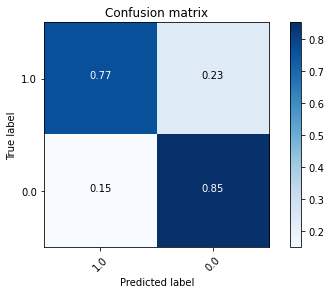

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##draw the confusion matrix
class_names=[1.0,0.0]
y_true = predictions.select("outcome")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()
#true positive rate is 0.77, and true negative rate is 0.85
#the predicting power is relatively high

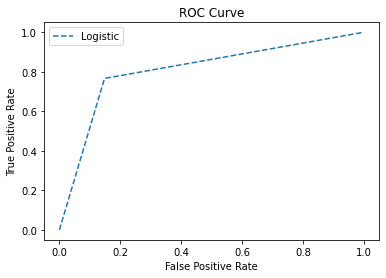

Area under the curve is:  0.8090753324236726


In [13]:
#ROC graph

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
# show the legend
plt.legend()
# show the plot
plt.show()

#AUC calculation: it is 0.8, which is pretty high and close to 1.

from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='outcome', metricName='areaUnderROC')
print("Area under the curve is: ", evaluator.evaluate(predictions))

#false positive rate at about 0.15 and true positive rate can reach 0.8, which is great tradeoff

In [15]:
#conduct cross validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 1.0, 2.0])# regularization parameter
             .addGrid(lr.maxIter, [5, 10, 15])#Number of iterations
             .build())
#create the cross validator model
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, 
                    evaluator=evaluator, numFolds=5)
#use the cross validator to fit the train set
cvModel = cv.fit(train)
#uset the cv model to predict the test set
cv_predictions = cvModel.transform(test)
#evaluate the performance of a cv model.
#AUC is 0.82, which is 0.02 higher than before, it is a slight improvement
print('Best Model Test Area Under ROC ', evaluator.evaluate(cv_predictions))
print('The parameters of the best model is ', cvModel.bestModel.explainParams().split("\n"))

Best Model Test Area Under ROC 0.8295519855496867
The parameters of the best model is  ['aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)', 'elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)', 'family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)', 'featuresCol: features column name. (default: features, current: vectorized_features)', 'fitIntercept: whether to fit an intercept term. (default: True)', 'labelCol: label column name. (default: label, current: outcome)', 'lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. 